In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("=== SIMPLIFIED MULTI-TIMEFRAME MOMENTUM STRATEGY ===")

# Parameters
SYMBOL = "XRP-USD"
START_DATE = "2025-01-01"
END_DATE = "2025-10-20"
INITIAL_CAPITAL = 1000
POSITION_SIZE_PCT = 0.90
TRANSACTION_FEE = 0.001 # Represented as decimal (0.1%)
STOP_LOSS_PCT = 0.03
TAKE_PROFIT_RATIO = 3.0
VOLUME_THRESHOLD = 1.2 # As a ratio to moving average

=== SIMPLIFIED MULTI-TIMEFRAME MOMENTUM STRATEGY ===


In [46]:
def download_and_prepare_data():
    """Download and prepare all timeframe data"""
    print("Downloading multi-timeframe data...")
    
    # Download all timeframes
    daily = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1d', progress=False)
    h4 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='4h', progress=False)
    h1 = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval='1h', progress=False)
    
    # Handle MultiIndex columns
    for df in [daily, h4, h1]:
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.droplevel(1) # Drop the second level (Ticker)
            
    # Normalize timestamps (remove timezone info if present)
    # Check if index is timezone-aware before trying to localize
    if daily.index.tz is not None:
        daily.index = pd.to_datetime(daily.index).tz_localize(None)
    else:
        daily.index = pd.to_datetime(daily.index)

    if h4.index.tz is not None:
         h4.index = pd.to_datetime(h4.index).tz_localize(None)
    else:
         h4.index = pd.to_datetime(h4.index)

    if h1.index.tz is not None:
         h1.index = pd.to_datetime(h1.index).tz_localize(None)
    else:
         h1.index = pd.to_datetime(h1.index)

    print(f"Daily: {len(daily)} records, 4H: {len(h4)} records, 1H: {len(h1)} records")
    return daily, h4, h1

# Example call (optional, just to test)
# daily_data, h4_data, h1_data = download_and_prepare_data()

#main execution
if __name__ == "__main__":
    #donwload and prepare data
    daily, h4, h1 = download_and_prepare_data()
    

Daily: 292 records, 4H: 1752 records, 1H: 7007 records


In [47]:
def add_indicators(df, timeframe='daily'):
    """Add technical indicators to dataframe"""
    # Clean column names first (lowercase, replace space with underscore)
    df.columns = [str(col).lower().replace(' ', '_') for col in df.columns]
    
    # Ensure required columns exist
    required_cols = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in required_cols):
        print(f"   ⚠️ Missing required columns in {timeframe} data. Cannot add indicators.")
        return df # Return original df if columns missing

    # Volume indicators
    df['volume_ma'] = df['volume'].rolling(20).mean()
    # Handle potential division by zero
    df['volume_ratio'] = df['volume'] / df['volume_ma'].replace(0, np.nan) 

    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

    # Support/Resistance based on timeframe lookback
    lookback = {'daily': 15, 'h4': 30, 'h1': 60}[timeframe]
    df['resistance'] = df['high'].rolling(lookback).max()
    df['support'] = df['low'].rolling(lookback).min()
    df['prev_resistance'] = df['resistance'].shift(1)
    df['prev_support'] = df['support'].shift(1) # Added prev_support based on usage

    return df

def check_daily_trend(daily_data, date):
    """Check if daily trend is bullish"""
    # Filter data up to the given date (inclusive)
    data_up_to_date = daily_data[daily_data.index <= date] 
    if len(data_up_to_date) < 30: # Need enough data for indicators
        return False, 0

    row = data_up_to_date.iloc[-1] # Get the latest row
    
    # Check if necessary indicator columns exist and are not NaN
    required_indicators = ['close', 'prev_resistance', 'volume_ratio', 'macd', 'macd_signal']
    if any(pd.isna(row[ind]) for ind in required_indicators):
        return False, 0

    conditions = [
        row['close'] > row['prev_resistance'],
        row['volume_ratio'] > VOLUME_THRESHOLD, # Assumes VOLUME_THRESHOLD is defined globally
        row['macd'] > row['macd_signal'],
        row['macd'] > 0,
    ]
    
    strength = sum(conditions) # Count how many conditions are True
    # Return True if at least 3 conditions are met
    return strength >= 3, strength 

def check_4h_momentum(h4_data, date):
    """Check if 4H momentum is confirmed"""
    # Take the last 48 bars (2 days of H4 data) up to the date
    data_up_to_date = h4_data[h4_data.index <= date].tail(48) 
    if len(data_up_to_date) < 20: # Need some history
        return False, 0

    row = data_up_to_date.iloc[-1]
    
    # Check if necessary indicator columns exist and are not NaN
    required_indicators = ['macd', 'macd_signal', 'volume_ratio', 'close', 'prev_support']
    if any(pd.isna(row[ind]) for ind in required_indicators):
         return False, 0
         
    recent_macd = data_up_to_date['macd'].tail(6) # Check last 6 periods of MACD
    if len(recent_macd) < 2: # Need at least 2 points to check trend
        return False, 0

    conditions = [
        row['macd'] > row['macd_signal'],
        recent_macd.iloc[-1] > recent_macd.iloc[-2], # MACD trending up in the last period
        data_up_to_date['volume_ratio'].tail(6).mean() > 1.0, # Recent volume is above average
        row['close'] > row['prev_support'] # Price bouncing off previous support
    ]
    
    strength = sum(conditions)
    # Return True if at least 3 conditions are met
    return strength >= 3, strength

def check_1h_entry(h1_data, date):
    """Check if 1H entry timing is optimal"""
    data_up_to_date = h1_data[h1_data.index <= date].tail(72) 
    if len(data_up_to_date) < 24: 
        return False, 0, data_up_to_date['close'].iloc[-1] if len(data_up_to_date) > 0 else 0 

    row = data_up_to_date.iloc[-1] 
    
    required_indicators = ['close', 'prev_support', 'volume_ratio', 'macd']
    if any(pd.isna(row[ind]) for ind in required_indicators) or len(data_up_to_date['macd'].tail(24).dropna()) < 1:
        return False, 0, row['close'] 

    recent_prices = data_up_to_date['close'].tail(12) 
    recent_volumes_ratio = data_up_to_date['volume_ratio'].tail(12) 
    recent_macd_abs = abs(data_up_to_date['macd'].tail(24)) 

    prev_support_val = row['prev_support']
    if pd.isna(prev_support_val):
        return False, 0, row['close']

    # --- PERBAIKAN DI SINI ---
    conditions = [ # Menggunakan list
        row['close'] > prev_support_val, 
        recent_prices.min() < prev_support_val * 1.02, 
        recent_volumes_ratio.tail(3).mean() < recent_volumes_ratio.mean() if len(recent_volumes_ratio) >=3 else False, 
        abs(row['macd']) < recent_macd_abs.mean() if not recent_macd_abs.empty else False 
    ]
    
    quality = sum(conditions) # Langsung jumlahkan list
    # --- AKHIR PERBAIKAN ---
    
    return quality >= 3, quality, row['close']

In [48]:
def generate_signals(daily_data, h4_data, h1_data):
    """Generate multi-timeframe signals"""
    signals = []
    start_idx = 50 # Skip initial periods for indicator stability

    print("Generating multi-timeframe signals...")

    # Iterate through daily data, starting after initial period
    for i, (date, _) in enumerate(daily_data.iloc[start_idx:].iterrows(), start_idx):

        # Check daily trend first
        daily_bullish, daily_strength = check_daily_trend(daily_data, date)
        if not daily_bullish:
            continue # Skip if daily trend is not bullish

        # Check 4H momentum
        h4_confirmed, h4_strength = check_4h_momentum(h4_data, date)
        if not h4_confirmed:
            continue # Skip if 4H momentum doesn't confirm

        # Check 1H entry timing
        h1_optimal, h1_quality, entry_price = check_1h_entry(h1_data, date)
        if not h1_optimal:
            continue # Skip if 1H entry is not optimal

        # Calculate confidence (sum of strengths / max possible strength)
        # Assuming max strength is 4 for daily, 4 for H4, 4 for H1 = 12
        confidence = (daily_strength + h4_strength + h1_quality) / 12 * 100

        signals.append({
            'date': date,
            'entry_price': entry_price, # Use entry price determined by 1H check
            'confidence': confidence
        })

    print(f"Generated {len(signals)} multi-timeframe signals")
    return signals

def generate_single_tf_signals(daily_data):
    """Generate single timeframe signals for comparison"""
    signals = []
    print("Generating single timeframe signals...")
    # Iterate starting from row 50
    for date, row in daily_data.iloc[50:].iterrows():
        # Check basic daily breakout conditions
        if (pd.notna(row['prev_resistance']) and # Make sure prev_resistance exists
            row['close'] > row['prev_resistance'] and
            row['volume_ratio'] > VOLUME_THRESHOLD and # Assumes global VOLUME_THRESHOLD
            row['macd'] > row['macd_signal']):
            
            signals.append({
                'date': date,
                'entry_price': row['close'] # Entry price is the closing price on signal day
            })

    print(f"Generated {len(signals)} single timeframe signals")
    return signals

In [49]:
def backtest_strategy(signals, daily_data):
    """Backtest trading strategy"""
    # Initialize backtest state
    cash = INITIAL_CAPITAL
    holdings = 0
    trades = []
    portfolio_values = []
    in_position = False

    # Create a dictionary for faster signal lookup by date
    signal_dict = {s['date'].date(): s for s in signals}

    # Iterate through daily data
    for date, row in daily_data.iterrows():
        # Ensure 'close' column name is correct
        current_price = row['close'] 

        # --- Entry logic ---
        # Check if we are not in position AND there's an entry signal for today
        if not in_position and date.date() in signal_dict:
            signal = signal_dict[date.date()]
            entry_price = signal['entry_price'] # Use entry price from signal
            
            # Calculate position size and cost
            position_value = cash * POSITION_SIZE_PCT
            total_cost = position_value * (1 + TRANSACTION_FEE)

            if cash >= total_cost:
                holdings = position_value / entry_price # Calculate crypto amount
                cash -= total_cost
                in_position = True

                # Calculate stop loss and take profit levels based on entry price
                stop_loss = entry_price * (1 - STOP_LOSS_PCT)
                take_profit = entry_price * (1 + STOP_LOSS_PCT * TAKE_PROFIT_RATIO)

                trades.append({
                    'action': 'BUY',
                    'date': date,
                    'price': entry_price, # Record actual entry price used
                    'stop_loss': stop_loss,
                    'take_profit': take_profit,
                    'value': position_value # Store the intended value before fees
                })

        # --- Exit logic ---
        elif in_position:
            # Need the last trade to access stop_loss and take_profit
            last_trade = trades[-1] if trades else None
            exit_triggered = False
            
            if last_trade: # Ensure there was a previous trade to get levels from
                exit_triggered = (current_price <= last_trade['stop_loss']) or \
                                 (current_price >= last_trade['take_profit'])

            if exit_triggered:
                # Calculate exit value and profit
                exit_value = holdings * current_price * (1 - TRANSACTION_FEE) # Net proceeds after fee
                # Calculate profit based on the initial value invested in the buy trade
                profit = exit_value - last_trade['value'] if last_trade else exit_value # Use fallback if no buy found

                # Update state
                cash += exit_value
                holdings = 0
                in_position = False

                trades.append({
                    'action': 'SELL',
                    'date': date,
                    'price': current_price,
                    'profit': profit
                })

        # --- Record daily portfolio value ---
        portfolio_value = cash + (holdings * current_price if in_position else 0)
        portfolio_values.append({'date': date, 'value': portfolio_value})

    # Return trades list and portfolio values DataFrame
    return trades, pd.DataFrame(portfolio_values).set_index('date')

Daily: 292 records, 4H: 1752 records, 1H: 7007 records

Adding indicators...
Generating multi-timeframe signals...
Generated 3 multi-timeframe signals
Generating single timeframe signals...
Generated 8 single timeframe signals

Backtesting strategies...

Analyzing results...

=== SINGLE TIMEFRAME RESULTS ===
Final Value: $950.31
Total Return: -4.97%
Completed Trades: 5
Win Rate: 40.0%
Max Drawdown: -25.22%
Sharpe Ratio: -0.08

=== MULTI-TIMEFRAME RESULTS ===
Final Value: $1,319.74
Total Return: +31.97%
Completed Trades: 3
Win Rate: 100.0%
Max Drawdown: -3.87%
Sharpe Ratio: 1.92


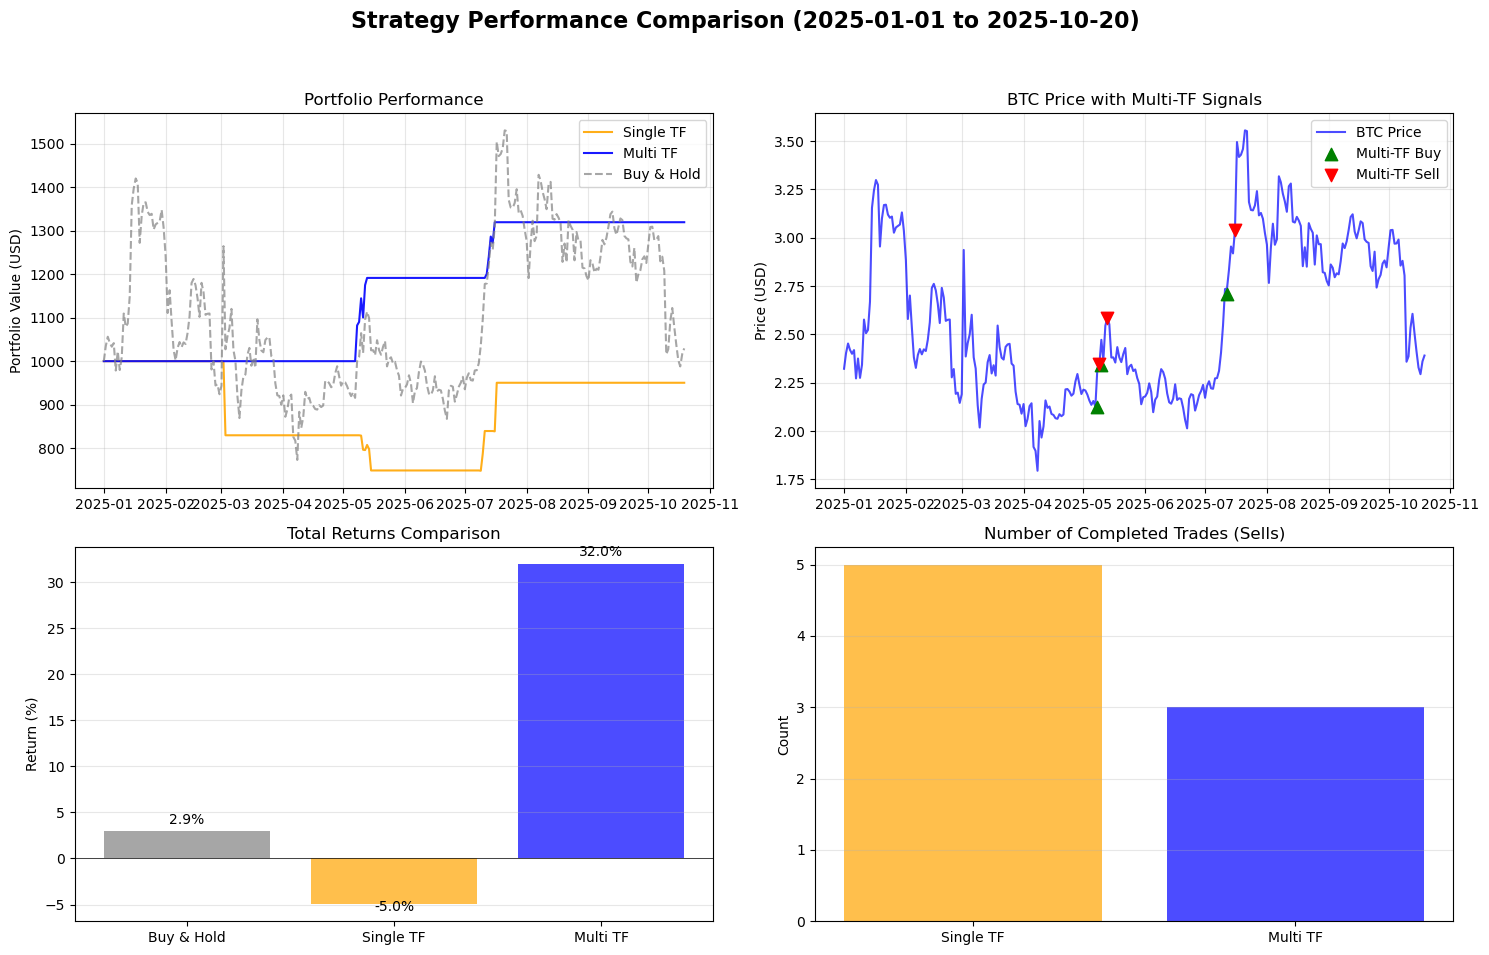


=== COMPARISON SUMMARY ===
Multi-TF vs Single-TF Return: +31.97% vs -4.97%
Multi-TF vs Single-TF Trades: 3 vs 5
Multi-TF vs Single-TF Win Rate: 100.0% vs 40.0%
Multi-TF vs Single-TF Sharpe: 1.92 vs -0.08
Average Multi-TF Signal Confidence: 88.9%

Multi-timeframe analysis complete!


In [50]:
# ==============================================================================
# 5. ANALYSIS & PLOTTING FUNCTIONS
# ==============================================================================
def analyze_results(trades, portfolio_df, strategy_name):
    """Analyze backtest results"""
    if portfolio_df.empty:
        print(f"\n=== {strategy_name.upper()} RESULTS ===")
        print("No portfolio data generated. Cannot analyze.")
        # Return default values or handle as needed
        return {'final_value': INITIAL_CAPITAL, 'total_return': 0, 'trades': 0, 'win_rate': 0, 'max_drawdown': 0, 'sharpe': 0}

    final_value = portfolio_df['value'].iloc[-1]
    total_return = (final_value / INITIAL_CAPITAL - 1) * 100
    completed_trades = [t for t in trades if t['action'] == 'SELL']
    # Calculate win rate safely
    win_rate = len([t for t in completed_trades if t['profit'] > 0]) / len(completed_trades) * 100 if completed_trades else 0

    # Risk metrics
    returns = portfolio_df['value'].pct_change().dropna()
    peak = portfolio_df['value'].expanding().max()
    drawdown = ((portfolio_df['value'] / peak) - 1)
    max_drawdown = drawdown.min() * 100 # In percentage

    # Simplified Sharpe Ratio (annualized), assumes risk_free_rate = 0
    annualized_return = returns.mean() * 252 if not returns.empty else 0
    annualized_volatility = returns.std() * np.sqrt(252) if not returns.empty else 0
    sharpe = annualized_return / annualized_volatility if annualized_volatility > 0 else 0

    print(f"\n=== {strategy_name.upper()} RESULTS ===")
    print(f"Final Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:+.2f}%")
    print(f"Completed Trades: {len(completed_trades)}")
    print(f"Win Rate: {win_rate:.1f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Sharpe Ratio: {sharpe:.2f}")

    return {
        'final_value': final_value,
        'total_return': total_return,
        'trades': len(completed_trades),
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'sharpe': sharpe
    }

def plot_comparison(single_results, multi_results, daily_data):
    """Plot strategy comparison"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Strategy Performance Comparison ({START_DATE} to {END_DATE})', fontsize=16, fontweight='bold') # Added dynamic title

    # --- Plot 1: Portfolio performance ---
    ax1.plot(single_results[1].index, single_results[1]['value'], label='Single TF', color='orange', alpha=0.9)
    ax1.plot(multi_results[1].index, multi_results[1]['value'], label='Multi TF', color='blue', alpha=0.9)
    # Buy & Hold using daily_data close prices
    bnh_portfolio = INITIAL_CAPITAL * (daily_data['close'] / daily_data['close'].iloc[0])
    ax1.plot(daily_data.index, bnh_portfolio, label='Buy & Hold', color='gray', alpha=0.7, linestyle='--')
    ax1.set_title('Portfolio Performance')
    ax1.set_ylabel('Portfolio Value (USD)') # Added Y label
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Plot 2: Price with signals (Example using Multi-TF signals on Daily chart) ---
    ax2.plot(daily_data.index, daily_data['close'], label='BTC Price', color='blue', alpha=0.7) # Added label
    # Plot multi_tf signals as an example
    multi_tf_trades = multi_results[0] # Get trades list
    buy_signals = [t for t in multi_tf_trades if t['action'] == 'BUY']
    sell_signals = [t for t in multi_tf_trades if t['action'] == 'SELL']
    if buy_signals:
         buy_dates = [t['date'] for t in buy_signals]; buy_prices = [t['price'] for t in buy_signals]
         ax2.scatter(buy_dates, buy_prices, color='green', marker='^', s=80, zorder=5, label='Multi-TF Buy') # Added label
    if sell_signals:
         sell_dates = [t['date'] for t in sell_signals]; sell_prices = [t['price'] for t in sell_signals]
         ax2.scatter(sell_dates, sell_prices, color='red', marker='v', s=80, zorder=5, label='Multi-TF Sell') # Added label
    ax2.set_title('BTC Price with Multi-TF Signals') # Title added
    ax2.set_ylabel('Price (USD)') # Added Y label
    ax2.legend() # Added legend
    ax2.grid(True, alpha=0.3)

    # --- Plot 3: Returns comparison ---
    # Calculate returns (using the DataFrames returned by backtest_strategy)
    single_return = (single_results[1]['value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100 if not single_results[1].empty else 0
    multi_return = (multi_results[1]['value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100 if not multi_results[1].empty else 0
    bnh_return = (daily_data['close'].iloc[-1] / daily_data['close'].iloc[0] - 1) * 100 if not daily_data.empty else 0

    strategies = ['Buy & Hold', 'Single TF', 'Multi TF']
    returns = [bnh_return, single_return, multi_return]
    colors = ['gray', 'orange', 'blue']

    bars = ax3.bar(strategies, returns, color=colors, alpha=0.7)
    ax3.set_title('Total Returns Comparison')
    ax3.set_ylabel('Return (%)')
    ax3.grid(True, axis='y', alpha=0.3) # Grid only on y-axis
    ax3.axhline(0, color='black', linewidth=0.5) # Zero line

    # Add labels to bars
    for bar, ret in zip(bars, returns):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 f'{ret:.1f}%', ha='center', va='bottom' if ret >=0 else 'top')

    # --- Plot 4: Trade count comparison ---
    single_trades_count = len([t for t in single_results[0] if t['action'] == 'SELL']) if single_results else 0
    multi_trades_count = len([t for t in multi_results[0] if t['action'] == 'SELL']) if multi_results else 0

    ax4.bar(['Single TF', 'Multi TF'], [single_trades_count, multi_trades_count],
            color=['orange', 'blue'], alpha=0.7)
    ax4.set_title('Number of Completed Trades (Sells)')
    ax4.set_ylabel('Count') # Changed label from 'Trades' to 'Count'
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for main title
    plt.show()

# ==============================================================================
# Main execution
# ==============================================================================
if __name__ == "__main__":
    # Download and prepare data
    daily, h4, h1 = download_and_prepare_data()

    # Proceed only if data download was successful
    if daily is not None and h4 is not None and h1 is not None:
        print("\nAdding indicators...")
        daily = add_indicators(daily, 'daily')
        h4 = add_indicators(h4, 'h4')
        h1 = add_indicators(h1, 'h1')

        multi_tf_signals = generate_signals(daily, h4, h1)
        single_tf_signals = generate_single_tf_signals(daily)

        # Backtest strategies
        print("\nBacktesting strategies...")
        single_results = backtest_strategy(single_tf_signals, daily)
        multi_results = backtest_strategy(multi_tf_signals, daily)

        # Check if backtest results are valid before analyzing
        if single_results and multi_results:
            print("\nAnalyzing results...")
            single_metrics = analyze_results(single_results[0], single_results[1], "Single Timeframe")
            multi_metrics = analyze_results(multi_results[0], multi_results[1], "Multi-Timeframe")

            plot_comparison(single_results, multi_results, daily)

            # Summary
            print(f"\n=== COMPARISON SUMMARY ===")
            print(f"Multi-TF vs Single-TF Return: {multi_metrics.get('total_return', 0):+.2f}% vs {single_metrics.get('total_return', 0):+.2f}%")
            print(f"Multi-TF vs Single-TF Trades: {multi_metrics.get('trades', 0)} vs {single_metrics.get('trades', 0)}")
            print(f"Multi-TF vs Single-TF Win Rate: {multi_metrics.get('win_rate', 0):.1f}% vs {single_metrics.get('win_rate', 0):.1f}%")
            print(f"Multi-TF vs Single-TF Sharpe: {multi_metrics.get('sharpe', 0):.2f} vs {single_metrics.get('sharpe', 0):.2f}")

            # Average Confidence (if multi_tf_signals is not empty)
            if len(multi_tf_signals) > 0:
                avg_confidence = sum(s['confidence'] for s in multi_tf_signals) / len(multi_tf_signals)
                print(f"Average Multi-TF Signal Confidence: {avg_confidence:.1f}%")

            print("\nMulti-timeframe analysis complete!")
        else:
            print("\nError during backtesting. Cannot analyze or plot results.")
    else:
        print("\nFailed to download data. Aborting analysis.")